In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [5]:
import pandas as pd
import numpy as np
snapshots_hist = pd.read_csv('/content/drive/MyDrive/New_Snapshots/snapshots_hist.csv')

In [6]:
# Removing Redundant feature created
# IGNORE
snapshots_hist.drop(columns=['batch_id_te'], inplace=True)

# \GMM

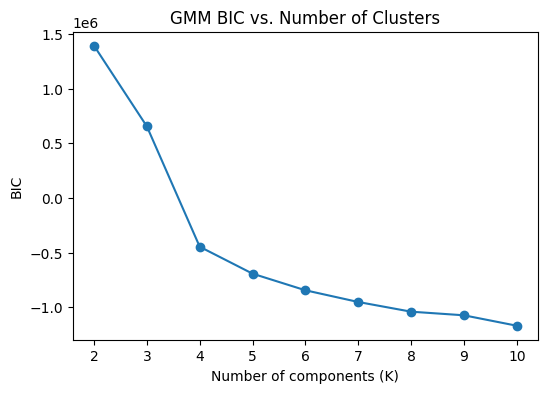

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# 1) Loading snapshot data
#napshots_hist = pd.read_csv('/content/drive/MyDrive/New_Snapshots/snapshots_hist_with_clusters.csv', parse_dates=['snapshot_date'])

# 2) Selecting the features you want to cluster on
features = [
    'total_events', 'pct_completed', 'days_since_last_event',
    'activity_trend', 'mean_gap', 'num_sessions',
    'sum_component_time', 'avg_component_time',
    'n_unique_components', 'pct_weekend_events'
]
X = snapshots_hist[features].fillna(0)

# 3) Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Choosing the number of components using BIC
bics = []
Ks = range(2, 11)
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))

plt.figure(figsize=(6,4))
plt.plot(Ks, bics, marker='o')
plt.xlabel('Number of components (K)')
plt.ylabel('BIC')
plt.title('GMM BIC vs. Number of Clusters')
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 1) Prepare & scale
X = snapshots_hist[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# 2) Fitting GMM with K=3
gmm3 = GaussianMixture(n_components=3, covariance_type='full', random_state=42).fit(X_scaled)
labels3 = gmm3.predict(X_scaled)

# 3) Computing silhouette
sil3 = silhouette_score(X_scaled, labels3, sample_size=5000, random_state=42)
print(f"Silhouette for K=3: {sil3:.3f}")

# 4) Comparing to K=4
gmm4 = GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X_scaled)
labels4 = gmm4.predict(X_scaled)
sil4 = silhouette_score(X_scaled, labels4, sample_size=5000, random_state=42)
print(f"Silhouette for K=4: {sil4:.3f}")


Silhouette for K=3: 0.053
Silhouette for K=4: 0.050


In [ ]:
 #5) Fitting the final GMM (
K_opt = 3
gmm_final = GaussianMixture(
    n_components=K_opt,
    covariance_type='full',
    random_state=42
).fit(X_scaled)

# 6) Assigning clusters (hard labels) and (optionally) soft probabilities
snapshots_hist['gmm_cluster'] = gmm_final.predict(X_scaled)
proba = gmm_final.predict_proba(X_scaled)
# proba[i, j] = probability that sample i belongs to cluster j

# 7) Inspecting cluster centroids in original feature space
centroids = scaler.inverse_transform(gmm_final.means_)
centroid_df = pd.DataFrame(centroids, columns=features)
print("Cluster centroids (mean feature values):\n", centroid_df)

# 8) Checking sizes
print("\nCluster sizes:\n", snapshots_hist['gmm_cluster'].value_counts().sort_index())

Cluster centroids (mean feature values):
    total_events  pct_completed  days_since_last_event  activity_trend  \
0     15.237975       0.647918              13.674247        0.000678   
1   1700.545479       0.927352              10.266874       12.973424   
2    150.050271       0.846868               9.702635        0.268117   

   mean_gap  num_sessions  sum_component_time  avg_component_time  \
0  0.410068      0.702830         1221.034787           77.701906   
1  0.009173      3.280955       148716.556452           82.959506   
2  0.100786      2.794674        12272.107941           83.727836   

   n_unique_components  pct_weekend_events  
0             6.582583            0.278576  
1            36.210807            0.269342  
2            21.692288            0.271240  

Cluster sizes:
 gmm_cluster
0    49001
1    26864
2    65516
Name: count, dtype: int64


In [ ]:
snapshots_hist.drop(columns=['batch_dropout_rate_hist','center_id'], inplace=True)
snapshots_hist['gmm_cluster'] = labels3
snapshots_hist['gmm_cluster'] = snapshots_hist['gmm_cluster'].astype(str)



In [ ]:
# Export the DataFrame to a CSV file in Google Drive
# snapshots_hist.to_csv('/content/drive/MyDrive/New_Snapshots/snapshots_hist_with_clusters.csv', index=False)
# print("snapshots_hist_with_clusters.csv exported successfully to Google Drive.")

# LightGBM


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import lightgbm as lgb

# 1) Making sure your dates are datetimes
snapshots_hist['snapshot_date'] = pd.to_datetime(
    snapshots_hist['snapshot_date'],
    errors='coerce'
)
snapshots_hist['gmm_cluster'] = snapshots_hist['gmm_cluster'].astype(str)


# 2. Splitting by time
cutoff = snapshots_hist['snapshot_date'].quantile(0.8)
train_df = snapshots_hist[snapshots_hist['snapshot_date'] <= cutoff].copy()
test_df  = snapshots_hist[snapshots_hist['snapshot_date'] >  cutoff].copy()


# 3. Defining features & drop columns LightGBM can't handle
drop_cols = [
    'user_id', 'snapshot_date', 'user_joining_date', 'label', 'batch_id','batch_dropout_rate','batch_avg_events'
]
feature_cols = [c for c in snapshots_hist.columns if c not in drop_cols]

X_train = pd.get_dummies(train_df[feature_cols], drop_first=True)
y_train = train_df['label']
X_test  = pd.get_dummies(test_df[feature_cols], drop_first=True)
y_test  = test_df['label']

# aligning columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 4. Training
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluating
y_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)
print(f'ROC AUC: {roc_auc:.4f}  |  PR AUC: {pr_auc:.4f}')

# 6. Top features
importances = pd.Series(model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(20))


[LightGBM] [Info] Number of positive: 66236, number of negative: 47512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 113748, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582305 -> initscore=0.332242
[LightGBM] [Info] Start training from score 0.332242
ROC AUC: 0.8279  |  PR AUC: 0.8395
days_since_join          388
days_since_last_quiz     284
days_since_last_event    228
topic_entropy            222
batch_avg_events_hist    190
sum_component_time       189
pct_completed            168
chapter_entropy          150
avg_component_time       148
activity_trend           144
total_events             129
pct_weekend_events       112
component_entropy        112
max_gap                  102
n_

##Permutation Importance

[LightGBM] [Info] Number of positive: 66236, number of negative: 47512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 113748, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582305 -> initscore=0.332242
[LightGBM] [Info] Start training from score 0.332242


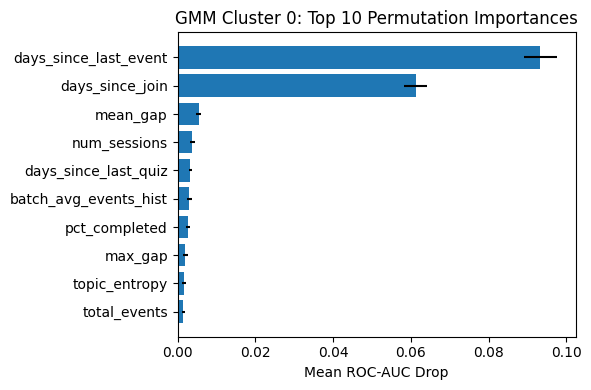

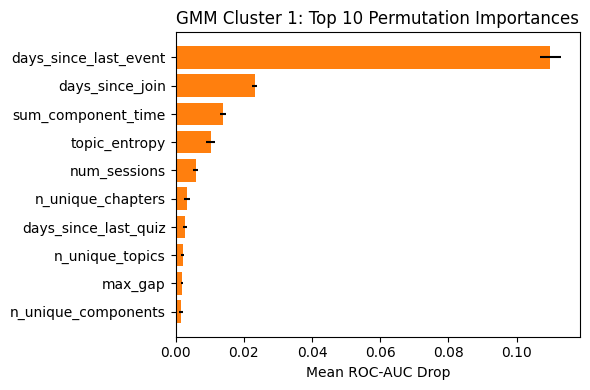

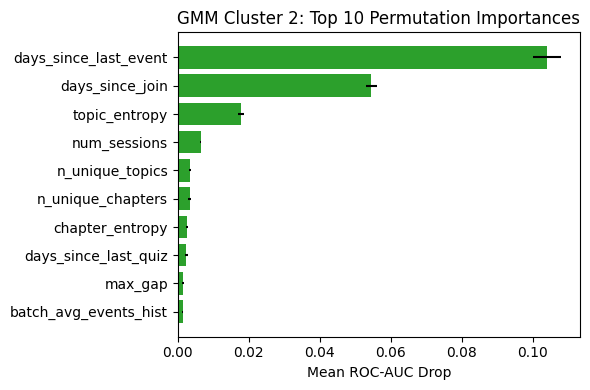

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# --- 2) Train/test split by time ---
# Assumes snapshots_hist, train_df, test_df, X_train, X_test, y_train, y_test are already defined
# and X_train and X_test include the 'gmm_cluster' column and are correctly formatted
# with categorical features handled (as done in cell -jio0ey7bxgw).


# Retraining the LightGBM model with the updated X_train and y_train
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Identifying categorical features for LightGBM by index
categorical_feature_names = ['gmm_cluster', 'center_id']
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_feature_names if col in X_train.columns]

model.fit(X_train, y_train,
          categorical_feature=categorical_feature_indices)


# --- 3) Per-cluster permutation importances ---
def auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:,1]
    return roc_auc_score(y, y_prob)

# Use the test_df and X_test that were prepared in previous cells
# Ensure test_df has the 'gmm_cluster' column and X_test is aligned with X_train

for c_str in sorted(test_df['gmm_cluster'].unique()):
    c = int(c_str) # Convert the string cluster label to an integer
    mask = test_df['gmm_cluster'] == c_str
    # Use the existing X_test and y_test and apply the mask
    Xc, yc = X_test.loc[mask], y_test.loc[mask]

    if len(yc) < 50:
        print(f"Skipping cluster {c_str} (n={len(yc)})—too few samples.")
        continue

    perm = permutation_importance(
        model, Xc, yc,
        scoring=auc_scorer,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    imp_df = (
        pd.DataFrame({
            'feature': Xc.columns,
            'mean_auc_drop': perm.importances_mean,
            'std_auc_drop' : perm.importances_std
        })
        .sort_values('mean_auc_drop', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(6,4))
    plt.barh(
        imp_df['feature'][::-1],
        imp_df['mean_auc_drop'][::-1],
        xerr=imp_df['std_auc_drop'][::-1],
        color=f"C{c % 10}"
    )
    plt.xlabel('Mean ROC-AUC Drop')
    plt.title(f'GMM Cluster {c_str}: Top 10 Permutation Importances')
    plt.tight_layout()
    plt.show()

Cluster summary:
   gmm_cluster  n_snapshots  dropout_rate
0           0         9507      0.640265
1           1         5576      0.507174
2           2        12550      0.495060
Will analyze clusters: ['0', '1', '2']

=== SHAP for GMM cluster 0 (n=9507) ===


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


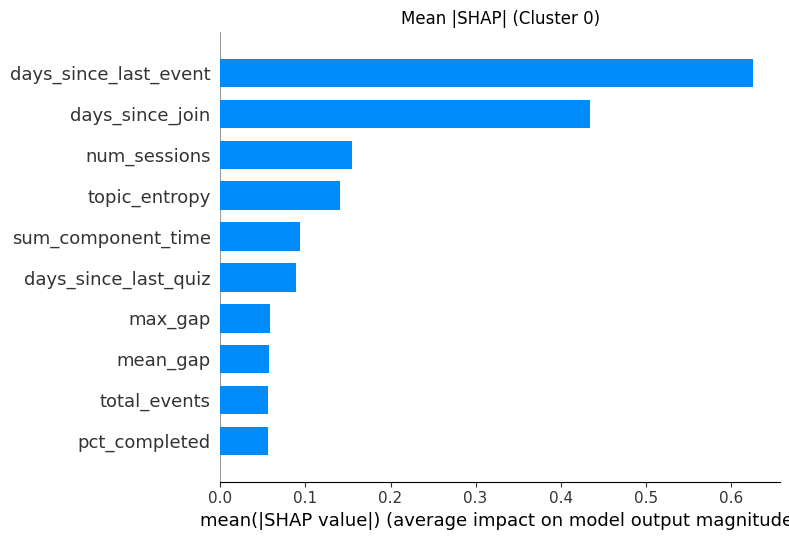

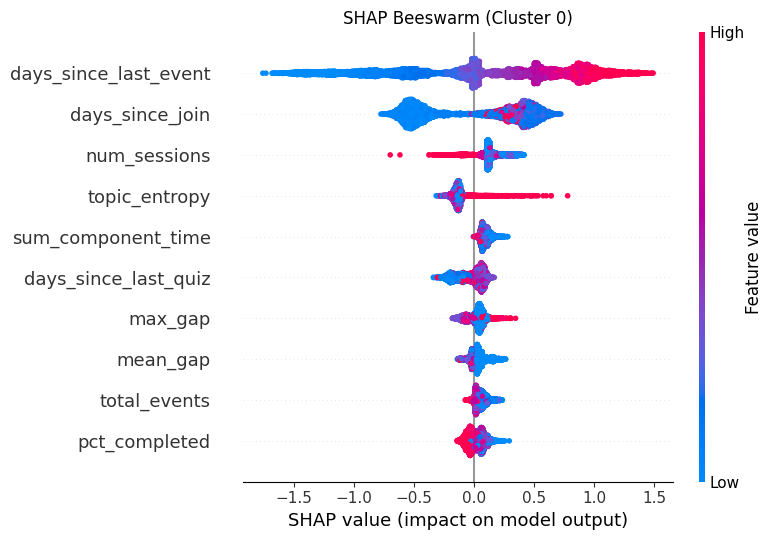


=== SHAP for GMM cluster 1 (n=5576) ===


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


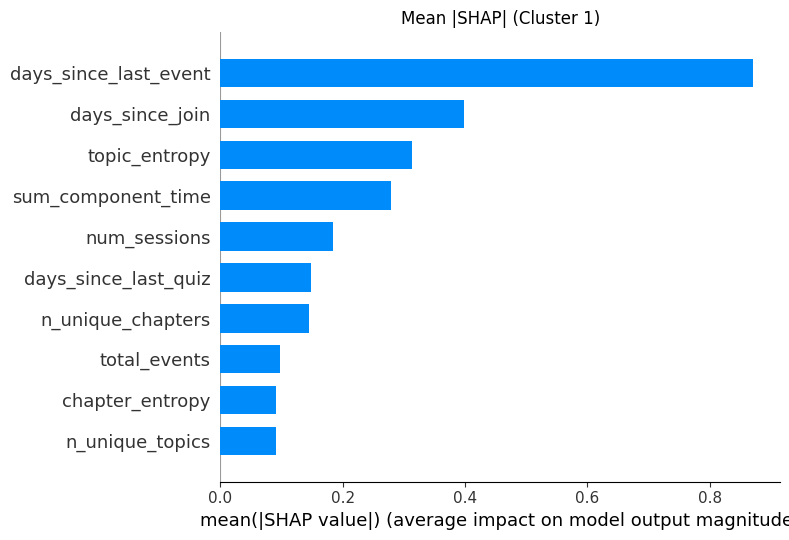

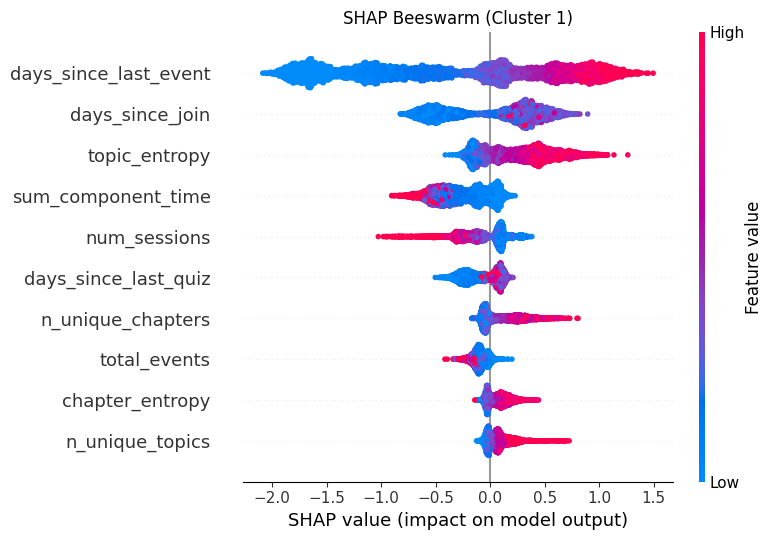


=== SHAP for GMM cluster 2 (n=12550) ===


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


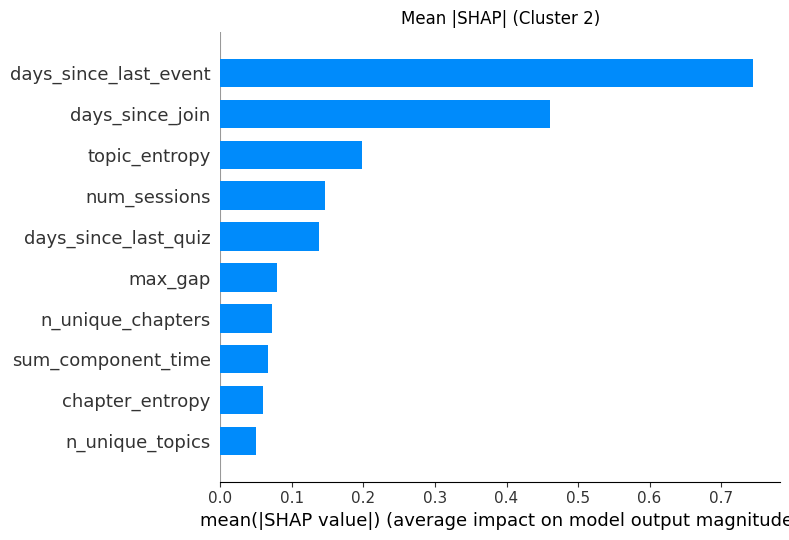

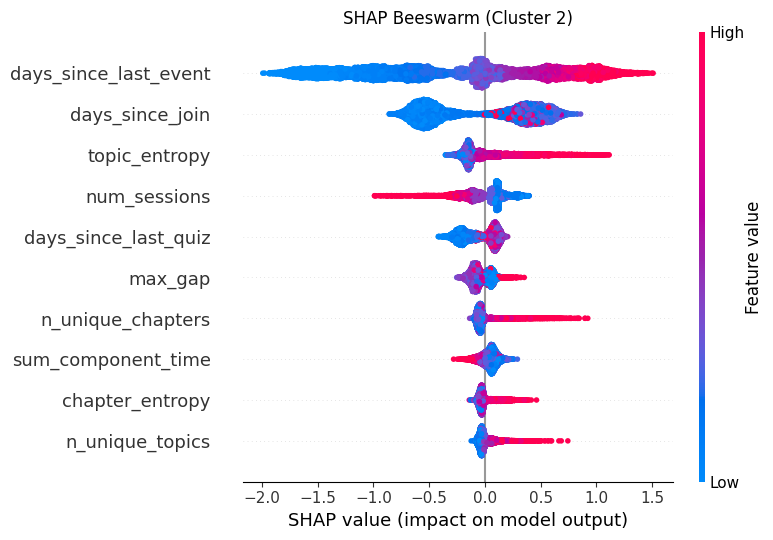

In [ ]:
import shap
import matplotlib.pyplot as plt


# 1) Building a small DataFrame aligned with X_test
test_df = snapshots_hist.loc[X_test.index]

# 2) SEGMENTATION: just inspect cluster sizes & dropout rates
seg_metrics = test_df.groupby('gmm_cluster').agg(
    n_snapshots  = ('label','size'),
    dropout_rate = ('label','mean')
).reset_index()
print("Cluster summary:\n", seg_metrics)

# 3) TARGETING: here we take \emph{all} clusters (0,1,2) that we already created
target_clusters = seg_metrics['gmm_cluster'].tolist()
print("Will analyze clusters:", target_clusters)

# 4) POSITIONING: per-cluster SHAP
explainer   = shap.TreeExplainer(model)
# note: we pass the list-of-arrays into summary_plot, so no manual slicing needed
for c in target_clusters:
    mask = test_df['gmm_cluster'] == c
    Xc   = X_test.loc[mask]
    if len(Xc) < 50:
        print(f"Skipping cluster {c} (n={len(Xc)}) — too small")
        continue

    print(f"\n=== SHAP for GMM cluster {c} (n={len(Xc)}) ===")
    shap_vals_c = explainer.shap_values(Xc)  # returns [shap_class0, shap_class1]

     # 4a) mean |SHAP| bar plot
    plt.figure(figsize=(6, 4)) # Reduced figure size
    shap.summary_plot(
        shap_vals_c,
        Xc,
        plot_type="bar",
        max_display=10,
        show=False
    )
    plt.title(f"Mean |SHAP| (Cluster {c})")
    plt.tight_layout()
    plt.show()
    # 4b) beeswarm
    plt.figure(figsize=(8, 5)) # Reduced figure size, adjusted aspect ratio
    shap.summary_plot(
        shap_vals_c,
        Xc,
        max_display=10,
        show=False
    )
    plt.title(f"SHAP Beeswarm (Cluster {c})")
    plt.tight_layout()
    plt.show()




/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


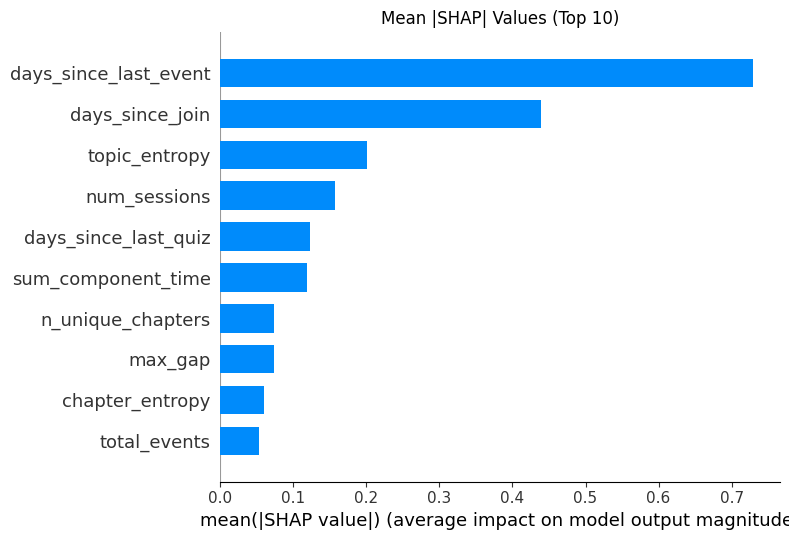

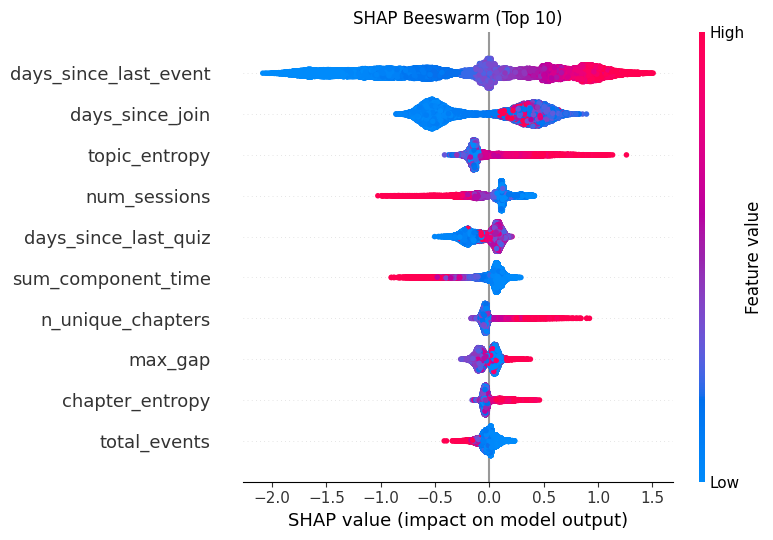

<Figure size 800x600 with 0 Axes>

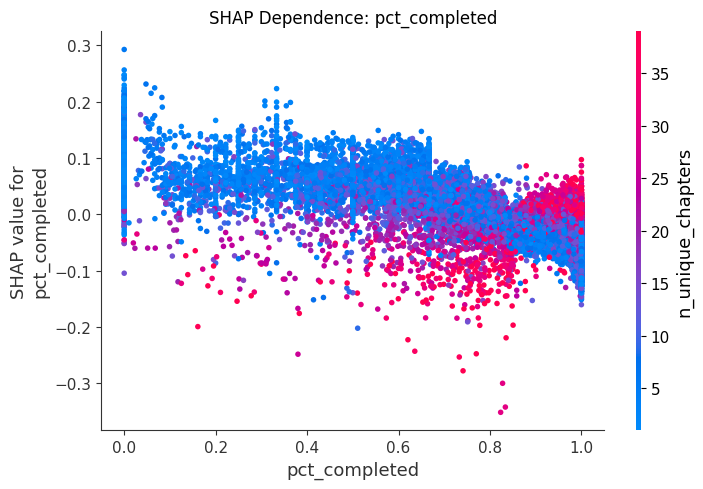

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Creating a SHAP explainer
explainer = shap.TreeExplainer(model)

# 2. Sampling
sample = X_test
shap_values = explainer.shap_values(sample)

# 3. Mean |SHAP| bar plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, sample, plot_type="bar", max_display=10, show=False)
plt.title("Mean |SHAP| Values (Top 10)")
plt.tight_layout()
plt.show()

# 4. Beeswarm summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, sample, max_display=10, show=False)
plt.title("SHAP Beeswarm (Top 10)")
plt.tight_layout()
plt.show()


# 6. Dependence: completion rate
plt.figure(figsize=(8,6))
shap.dependence_plot("pct_completed", shap_values, sample, show=False)
plt.title("SHAP Dependence: pct_completed")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


# 1) Computing cluster sizes and shares
total_snaps = len(snapshots_hist)
cluster_counts = snapshots_hist['gmm_cluster'].value_counts().sort_index()
cluster_shares = (cluster_counts / total_snaps * 100).round(1)
segment_sizes_df = pd.DataFrame({
    'cluster': cluster_counts.index,
    'size': cluster_counts.values,
    'share_pct': cluster_shares.values
})
print("Cluster sizes and shares:\n", segment_sizes_df)

# 2) Training & evaluating a separate LightGBM for each cluster
results = []
for c in segment_sizes_df['cluster']:
    # Mask train/test by cluster
    tr_mask = train_df['gmm_cluster'] == c
    te_mask = test_df['gmm_cluster'] == c

    Xc_train = X_train.loc[tr_mask]
    yc_train = y_train.loc[tr_mask]
    Xc_test  = X_test.loc[te_mask]
    yc_test  = y_test.loc[te_mask]

    # Skip small test sets
    if len(yc_test) < 20:
        print(f"Skipping cluster {c}: only {len(yc_test)} test snapshots.")
        continue

    # Instantiating LightGBM with tuned hyperparameters
    model_c = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=20,
        num_leaves=100,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.6,
        reg_alpha=1.0,
        reg_lambda=0.0,
        random_state=42
    )

    # Training
    model_c.fit(Xc_train, yc_train)

    # Predicting and evaluating
    y_prob = model_c.predict_proba(Xc_test)[:, 1]
    auc = roc_auc_score(yc_test, y_prob)

    results.append({
        'cluster': c,
        'size': segment_sizes_df.loc[segment_sizes_df['cluster'] == c, 'size'].values[0],
        'share_pct': segment_sizes_df.loc[segment_sizes_df['cluster'] == c, 'share_pct'].values[0],
        'roc_auc': round(auc, 4)
    })

segment_eval_df = pd.DataFrame(results).sort_values('cluster').reset_index(drop=True)
print("\nSegment-level ROC AUC evaluation:\n", segment_eval_df)


Cluster sizes and shares:
   cluster   size  share_pct
0       0  49001       34.7
1       1  26864       19.0
2       2  65516       46.3
[LightGBM] [Info] Number of positive: 26028, number of negative: 13466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 39494, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.659037 -> initscore=0.659005
[LightGBM] [Info] Start training from score 0.659005
[LightGBM] [Info] Number of positive: 12295, number of negative: 8993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 21288, number of used features: 21
[LightGBM]

In [ ]:
# Add the cluster assignments to the snapshots_hist DataFrame
# Assuming 'labels3' contains the cluster labels from the GMM fit with K=3
snapshots_hist['gmm_cluster'] = labels3

# Defining features, including the new 'gmm_cluster'
drop_cols = [
    'user_id', 'snapshot_date', 'user_joining_date', 'label', 'batch_id',
]
feature_cols = [c for c in snapshots_hist.columns if c not in drop_cols]

# Splitting by time (re-doing this to include the new column)
cutoff = snapshots_hist['snapshot_date'].quantile(0.8)
train_df = snapshots_hist[snapshots_hist['snapshot_date'] <= cutoff].copy()
test_df  = snapshots_hist[snapshots_hist['snapshot_date'] >  cutoff].copy()


X_train = train_df[feature_cols]
y_train = train_df['label']
X_test  = test_df[feature_cols]
y_test  = test_df['label']

# Identifying categorical features for LightGBM
categorical_features = ['gmm_cluster'] # Assuming center_id is also categorical

# Converting categorical columns to 'category' dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


# Aligning columns after adding 'gmm_cluster'
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


#training LightGBM using X_train, y_train and specifying categorical_feature

model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train,
          categorical_feature=categorical_features)

#And evaluating as before:
y_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
from sklearn.metrics import auc # Import auc again to avoid the TypeError
pr_auc = auc(rec, prec)
print(f'ROC AUC: {roc_auc:.4f}  |  PR AUC: {pr_auc:.4f}')

[LightGBM] [Info] Number of positive: 66236, number of negative: 47512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 113748, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582305 -> initscore=0.332242
[LightGBM] [Info] Start training from score 0.332242
ROC AUC: 0.8282  |  PR AUC: 0.8396


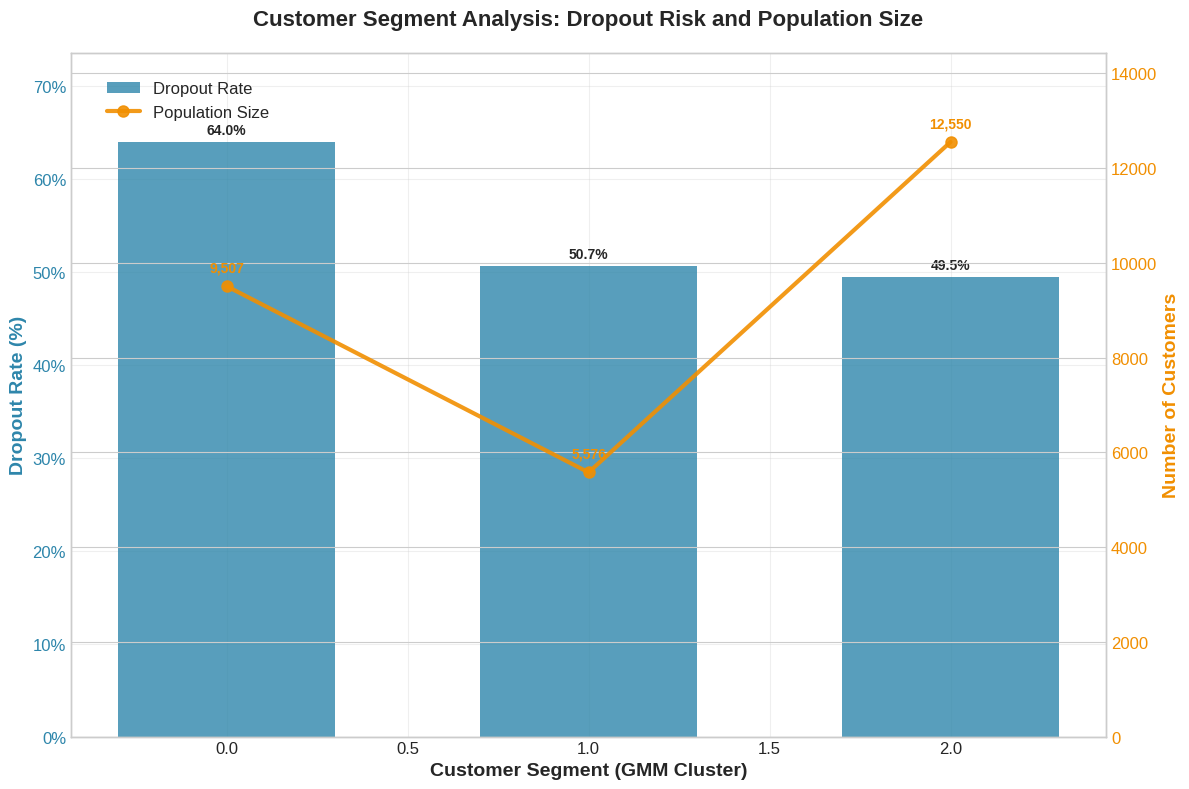

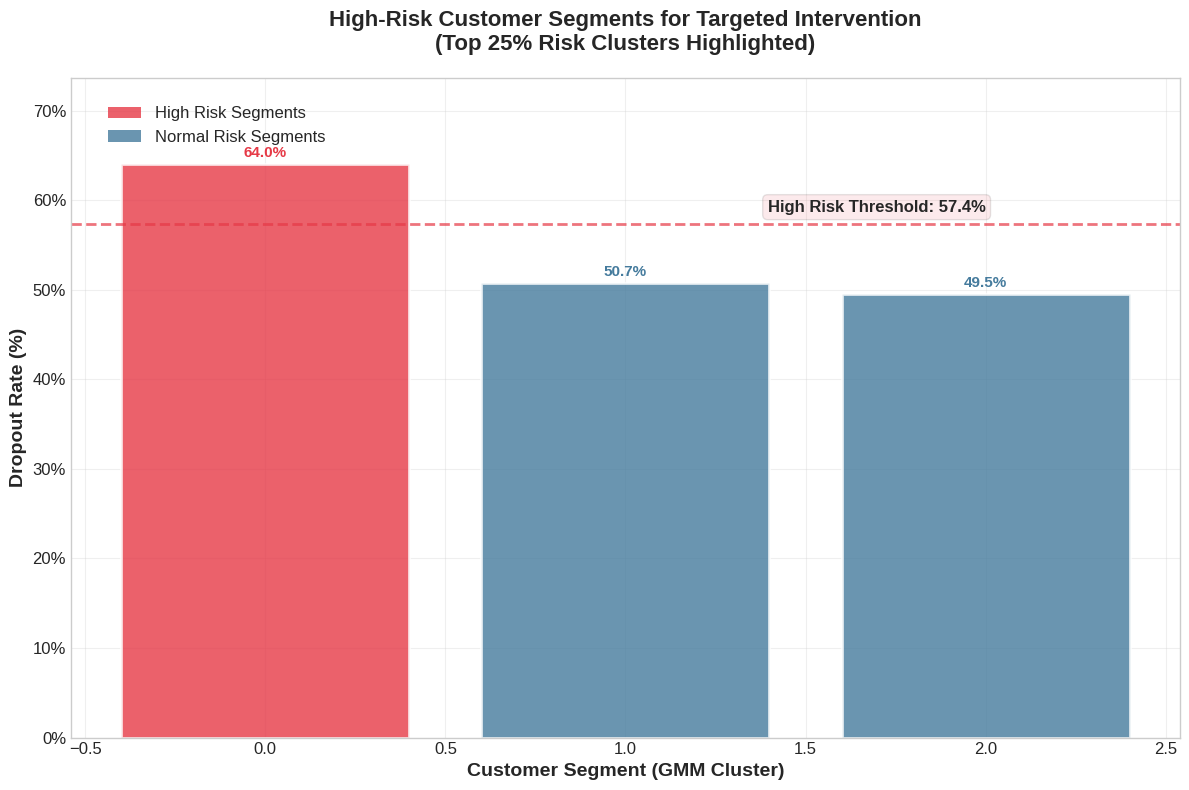

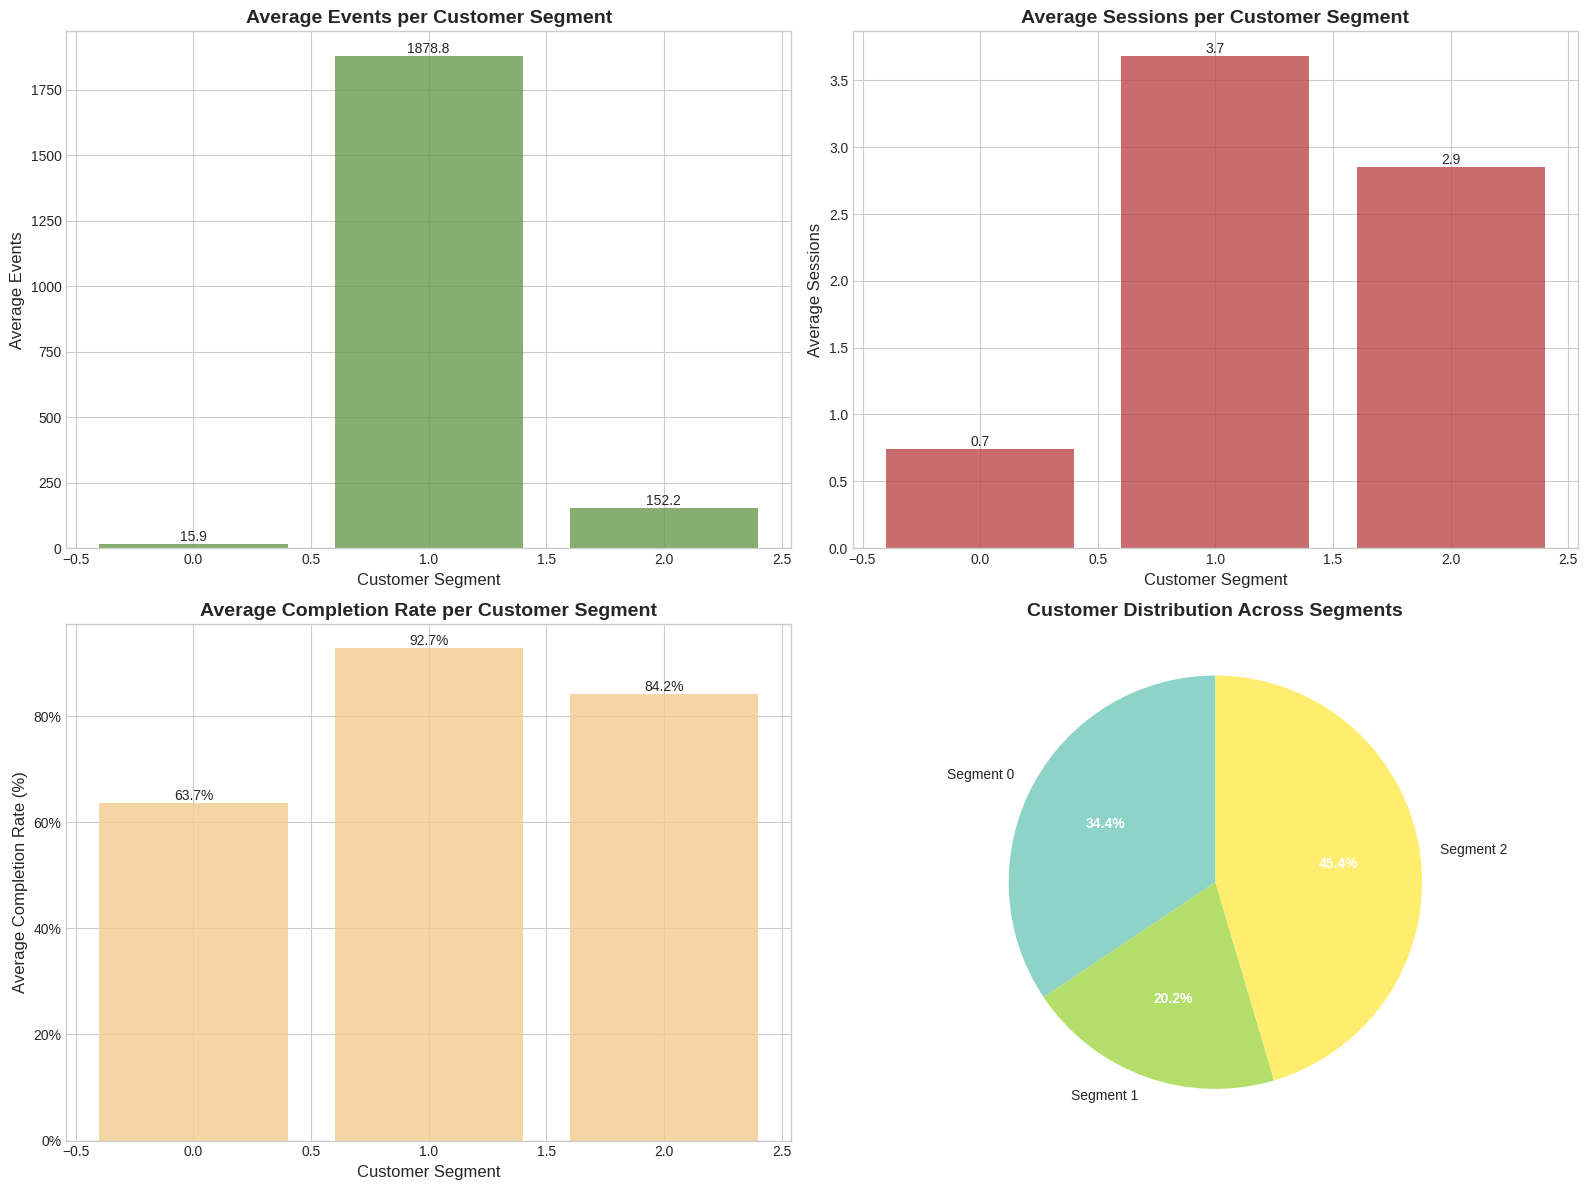


CUSTOMER SEGMENT ANALYSIS SUMMARY
Total Customers Analyzed: 27,633
Number of Segments: 3
Overall Dropout Rate: 54.7%
High-Risk Threshold (75th percentile): 57.4%
Number of High-Risk Segments: 1
Customers in High-Risk Segments: 9,507

DETAILED SEGMENT BREAKDOWN:
--------------------------------------------------------------------------------
 Segment Risk Level  Customers Dropout Rate  Avg Events  Avg Sessions  Avg Completion
       0  HIGH RISK       9507        64.0%        15.9           0.7             0.6
       1     NORMAL       5576        50.7%      1878.8           3.7             0.9
       2     NORMAL      12550        49.5%       152.2           2.9             0.8


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

# Set style for professional appearance
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# 1) Computing segment summary metrics
test_df = snapshots_hist.loc[X_test.index]
seg_metrics = test_df.groupby('gmm_cluster').agg(
    n_snapshots=('label','size'),
    dropout_rate=('label','mean'),
    avg_events=('total_events','mean'),
    avg_sessions=('num_sessions','mean'),
    avg_completion=('pct_completed','mean')
).reset_index()

# Sorting by dropout rate for better visualization
seg_metrics = seg_metrics.sort_values('dropout_rate', ascending=False)

# 2) Enhanced segmentation visualization: dropout rate & cluster size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Creating bars for dropout rate
bars1 = ax1.bar(seg_metrics['gmm_cluster'], seg_metrics['dropout_rate'],
                color='#2E86AB', alpha=0.8, label='Dropout Rate', width=0.6)

# Adding value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configuring the primary y-axis
ax1.set_ylabel('Dropout Rate (%)', fontsize=14, fontweight='bold', color='#2E86AB')
ax1.set_xlabel('Customer Segment (GMM Cluster)', fontsize=14, fontweight='bold')
ax1.set_title('Customer Segment Analysis: Dropout Risk and Population Size',
              fontsize=16, fontweight='bold', pad=20)
ax1.set_ylim(0, seg_metrics['dropout_rate'].max() * 1.15)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax1.tick_params(axis='y', labelcolor='#2E86AB', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Creating the secondary y-axis for population size
ax2 = ax1.twinx()
line = ax2.plot(seg_metrics['gmm_cluster'], seg_metrics['n_snapshots'],
                color='#F18F01', marker='o', linewidth=3, markersize=8,
                label='Population Size', alpha=0.9)

# Adding value labels for population
for i, (cluster, size) in enumerate(zip(seg_metrics['gmm_cluster'], seg_metrics['n_snapshots'])):
    ax2.text(cluster, size + max(seg_metrics['n_snapshots']) * 0.02,
             f'{size:,}', ha='center', va='bottom', fontsize=10,
             fontweight='bold', color='#F18F01')

ax2.set_ylabel('Number of Customers', fontsize=14, fontweight='bold', color='#F18F01')
ax2.tick_params(axis='y', labelcolor='#F18F01', labelsize=12)
ax2.set_ylim(0, seg_metrics['n_snapshots'].max() * 1.15)

# Adding legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
           bbox_to_anchor=(0.02, 0.98), fontsize=12)

# Adding grid for better readability
ax1.grid(True, alpha=0.3)
ax1.set_axisbelow(True)

plt.tight_layout()
plt.show()

# 3) Enhanced targeting visualization: highlight highest-risk clusters
risk_threshold = seg_metrics['dropout_rate'].quantile(0.75)
high_risk_clusters = seg_metrics[seg_metrics['dropout_rate'] >= risk_threshold]['gmm_cluster']

fig, ax = plt.subplots(figsize=(12, 8))

# Creating color mapping
colors = ['#E63946' if c in high_risk_clusters.values else '#457B9D'
          for c in seg_metrics['gmm_cluster']]

# Creating bars
bars = ax.bar(seg_metrics['gmm_cluster'], seg_metrics['dropout_rate'],
              color=colors, alpha=0.8, edgecolor='white', linewidth=2)

# Adding value labels on bars
for bar, cluster in zip(bars, seg_metrics['gmm_cluster']):
    height = bar.get_height()
    is_high_risk = cluster in high_risk_clusters.values
    label_color = '#E63946' if is_high_risk else '#457B9D'
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.1%}', ha='center', va='bottom',
            fontsize=11, fontweight='bold', color=label_color)

# Adding horizontal line for risk threshold
ax.axhline(y=risk_threshold, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)
ax.text(seg_metrics['gmm_cluster'].iloc[-1], risk_threshold + 0.01,
        f'High Risk Threshold: {risk_threshold:.1%}',
        ha='right', va='bottom', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#E63946', alpha=0.1))

# Configuring axes
ax.set_xlabel('Customer Segment (GMM Cluster)', fontsize=14, fontweight='bold')
ax.set_ylabel('Dropout Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('High-Risk Customer Segments for Targeted Intervention\n(Top 25% Risk Clusters Highlighted)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, seg_metrics['dropout_rate'].max() * 1.15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.tick_params(axis='both', labelsize=12)

# Adding custom legend
high_risk_patch = Rectangle((0,0), 1, 1, facecolor='#E63946', alpha=0.8, label='High Risk Segments')
normal_risk_patch = Rectangle((0,0), 1, 1, facecolor='#457B9D', alpha=0.8, label='Normal Risk Segments')
ax.legend(handles=[high_risk_patch, normal_risk_patch], loc='upper left',
          bbox_to_anchor=(0.02, 0.98), fontsize=12)

# Adding grid
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# 4) Additional comprehensive segment overview
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Average Events per Segment
bars1 = ax1.bar(seg_metrics['gmm_cluster'], seg_metrics['avg_events'],
                color='#6A994E', alpha=0.8)
ax1.set_title('Average Events per Customer Segment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Customer Segment', fontsize=12)
ax1.set_ylabel('Average Events', fontsize=12)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# Average Sessions per Segment
bars2 = ax2.bar(seg_metrics['gmm_cluster'], seg_metrics['avg_sessions'],
                color='#BC4749', alpha=0.8)
ax2.set_title('Average Sessions per Customer Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Customer Segment', fontsize=12)
ax2.set_ylabel('Average Sessions', fontsize=12)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# Average Completion Rate per Segment
bars3 = ax3.bar(seg_metrics['gmm_cluster'], seg_metrics['avg_completion'],
                color='#F2CC8F', alpha=0.8)
ax3.set_title('Average Completion Rate per Customer Segment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Customer Segment', fontsize=12)
ax3.set_ylabel('Average Completion Rate (%)', fontsize=12)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Segment Size Distribution (Pie Chart)
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(seg_metrics)))
wedges, texts, autotexts = ax4.pie(seg_metrics['n_snapshots'],
                                   labels=[f'Segment {c}' for c in seg_metrics['gmm_cluster']],
                                   autopct='%1.1f%%', startangle=90, colors=colors_pie)
ax4.set_title('Customer Distribution Across Segments', fontsize=14, fontweight='bold')

# Enhancing pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# 5) Summary statistics table
print("\n" + "="*80)
print("CUSTOMER SEGMENT ANALYSIS SUMMARY")
print("="*80)
print(f"Total Customers Analyzed: {seg_metrics['n_snapshots'].sum():,}")
print(f"Number of Segments: {len(seg_metrics)}")
print(f"Overall Dropout Rate: {test_df['label'].mean():.1%}")
print(f"High-Risk Threshold (75th percentile): {risk_threshold:.1%}")
print(f"Number of High-Risk Segments: {len(high_risk_clusters)}")
print(f"Customers in High-Risk Segments: {seg_metrics[seg_metrics['gmm_cluster'].isin(high_risk_clusters)]['n_snapshots'].sum():,}")
print("="*80)

# Detailed segment breakdown
seg_summary = seg_metrics.copy()
seg_summary['risk_level'] = seg_summary['dropout_rate'].apply(
    lambda x: 'HIGH RISK' if x >= risk_threshold else 'NORMAL'
)
seg_summary['dropout_rate_pct'] = seg_summary['dropout_rate'].apply(lambda x: f"{x:.1%}")
seg_summary = seg_summary[['gmm_cluster', 'risk_level', 'n_snapshots', 'dropout_rate_pct',
                          'avg_events', 'avg_sessions', 'avg_completion']]
seg_summary.columns = ['Segment', 'Risk Level', 'Customers', 'Dropout Rate',
                      'Avg Events', 'Avg Sessions', 'Avg Completion']

print("\nDETAILED SEGMENT BREAKDOWN:")
print("-" * 80)
print(seg_summary.to_string(index=False, float_format='%.1f'))
print("="*80)
